In [2]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 528.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 kB 1.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 2.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 450.6 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 340.8 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 1.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 162.7 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 76.4 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 625.3 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━

Počet výjezdů 65 457
Počet záznamů o vyslaných jednotkách: 33 219
Počet výjezdů bez jednotek: 56 151 



Typy výjezdů a jejich počet:
Typ výjezdu                             Počet
---------------------------------------------
Dopravní nehoda                        19 606
Technická pomoc                        18 845
Požár                                  17 106
Záchrana osob a zvířat                  4 874
Únik nebezpečných látek                 4 861
Jiná událost                               29
Formálně založená událost                  23
Technologický test                          1


Okresy s více než 50 výjezdy:
Okres                                   Počet
---------------------------------------------
Brno-město                             18 180
Brno-venkov                            14 391
Blansko                                 7 365
Břeclav                                 6 594
Hodonín                                 6 464
Znojmo                                  6 345
Vyškov

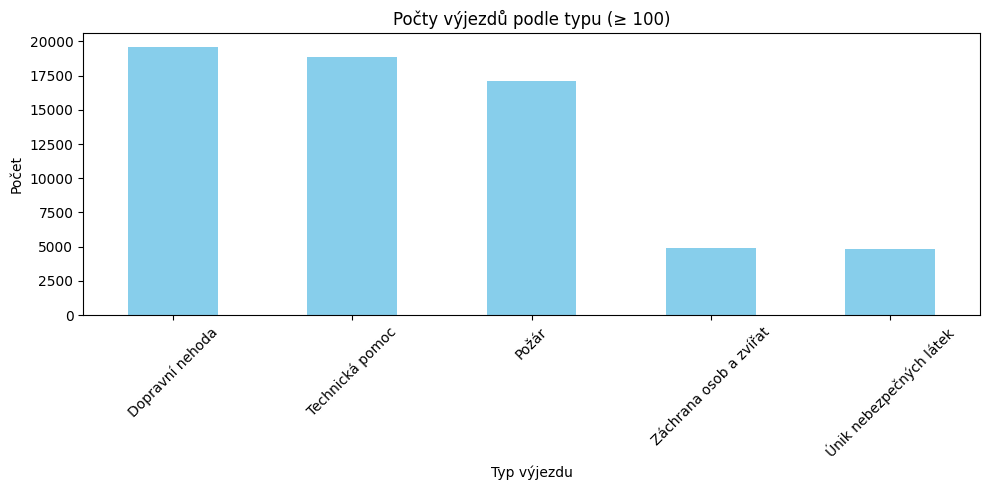

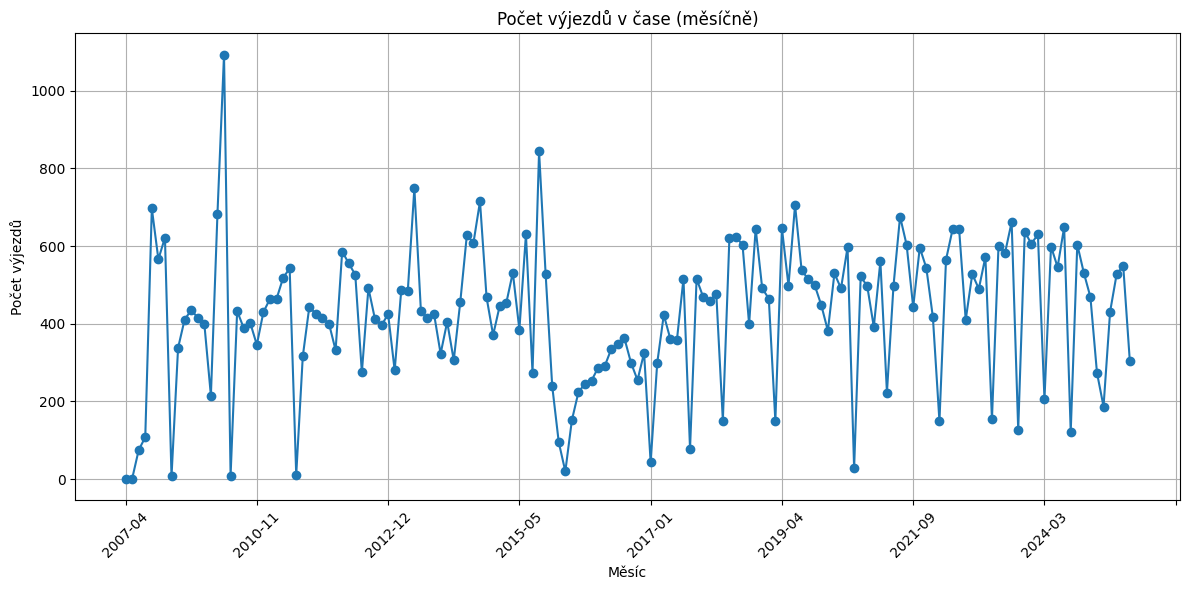

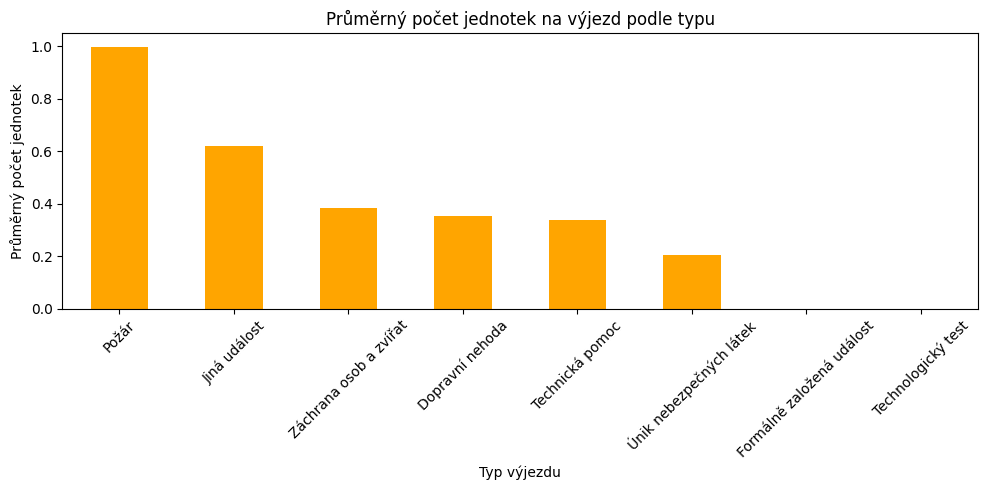

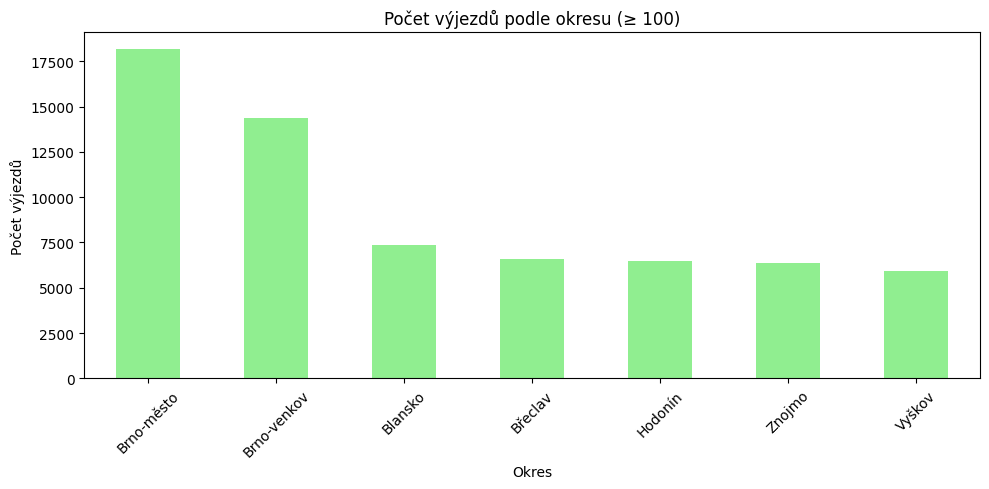

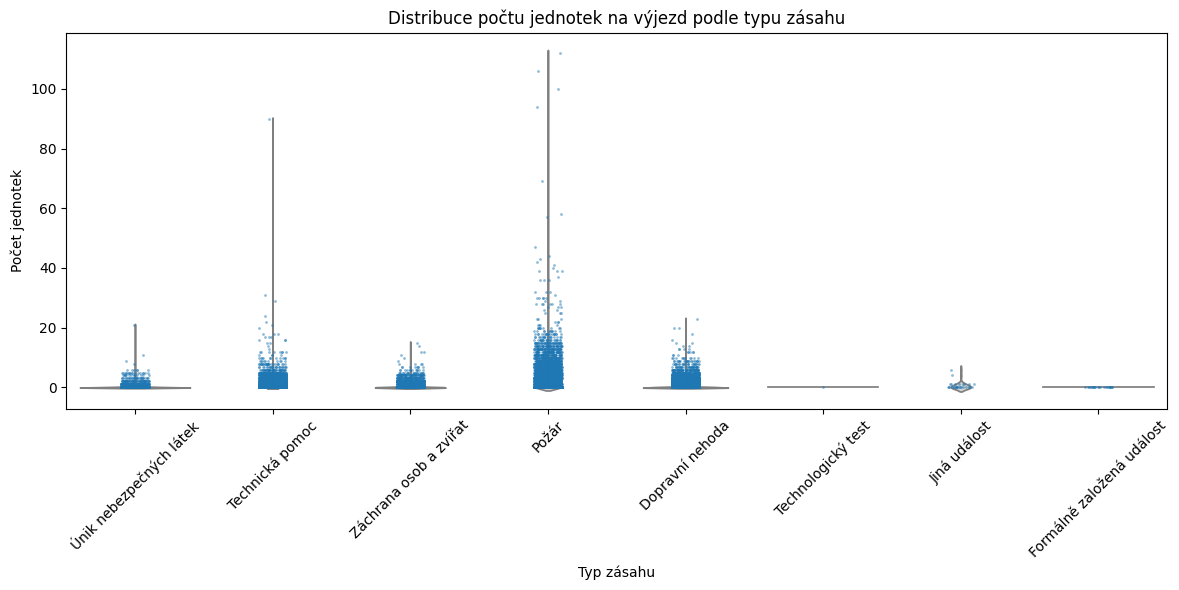

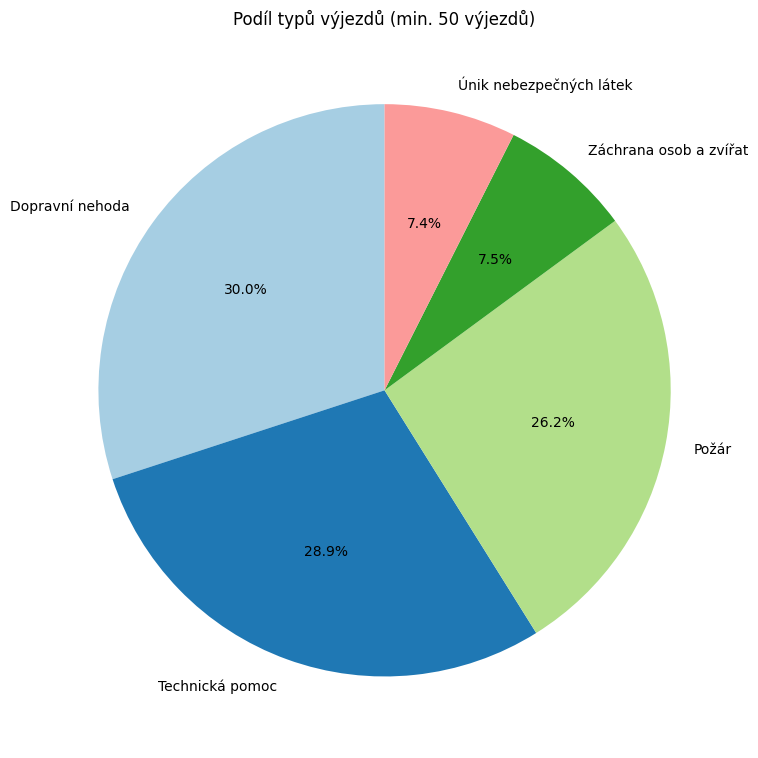

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
import os

mongo_01_ip = 'nosql-router-01'
mongo_02_ip = 'nosql-router-02'
mongo_port1 = 27017
mongo_port2 = 27017
mongo_database = os.getenv('DATABASE_NAME')
mongo_user = os.getenv('ROOT_USERNAME')
mongo_password = os.getenv('ROOT_PASSWORD')

mongo_url = f'mongodb://{mongo_user}:{mongo_password}@{mongo_01_ip}:{mongo_port1},{mongo_02_ip}:{mongo_port2}/{mongo_database}?authSource=admin'
client = MongoClient(mongo_url)
db = client[mongo_database]

# Načtení dat z kolekcí
df_addresses = pd.DataFrame(list(db.addresses.find()))
df_departures = pd.DataFrame(list(db.departures.find()))
df_sent_units = pd.DataFrame(list(db.sent_units.find()))

# Spojení dat
df = df_departures.merge(df_addresses, on="departure_id", how="left")
df_full = df.merge(df_sent_units.groupby("departure_id").agg({"unit": "count"}).rename(columns={"unit": "units_count"}), on="departure_id", how="left")
df_full["units_count"] = df_full["units_count"].fillna(0)

# -------------------------------
# ANALÝZA A VIZUALIZACE
# -------------------------------
# Počet výjezdů
pocet_vyjezdu = df["departure_id"].nunique()

# Počet záznamů o vyslaných jednotkách
pocet_jednotek = df_sent_units.shape[0]

# Počet výjezdů bez záznamu o jednotkách
vyjezdy_bez_jednotek = df[~df["departure_id"].isin(df_sent_units["departure_id"])].shape[0]

# Počet výjezdů podle typu
typy_vyjezdu = df["type"].value_counts()

# Počet výjezdů podle okresu s filtrem > 50
df["district_name"] = df["district"].apply(lambda x: x.get("name") if isinstance(x, dict) else None)
okresy_50plus = df["district_name"].value_counts()
okresy_50plus = okresy_50plus[okresy_50plus > 50]

# Výpis základních statistik
print("Počet výjezdů", f"{pocet_vyjezdu:,}".replace(",", " "))
print("Počet záznamů o vyslaných jednotkách:", f"{pocet_jednotek:,}".replace(",", " "))
print("Počet výjezdů bez jednotek:", f"{vyjezdy_bez_jednotek:,}".replace(",", " "), '\n')

print()
print()

typy_vyjezdu_df = df["type"].value_counts().reset_index()
typy_vyjezdu_df.columns = ["Typ výjezdu", "Počet"]

# Formátování čísel
typy_vyjezdu_df["Počet"] = typy_vyjezdu_df["Počet"].apply(lambda x: f"{x:,}".replace(",", " "))

# Výpis typů výjezdů
print("Typy výjezdů a jejich počet:")
print(f"{'Typ výjezdu':<35}{'Počet':>10}")
print("-" * 45)
for typ, pocet in typy_vyjezdu_df.values:
    print(f"{typ:<35}{pocet:>10}")

print()
print()

okresy_df = okresy_50plus.reset_index()
okresy_df.columns = ["Okres", "Počet"]

# Formátování čísel
okresy_df["Počet"] = okresy_df["Počet"].apply(lambda x: f"{x:,}".replace(",", " "))

# Výpis výjezdů v okresech
print("Okresy s více než 50 výjezdy:")
print(f"{'Okres':<35}{'Počet':>10}")
print("-" * 45)
for okres, pocet in okresy_df.values:
    print(f"{okres:<35}{pocet:>10}")


# Počty výjezdů podle typu
plt.figure(figsize=(10,5))
type_counts = df["type"].value_counts()
type_counts = type_counts[type_counts >= 100]
type_counts.plot(kind="bar", color="skyblue")
plt.title("Počty výjezdů podle typu (≥ 100)")
plt.ylabel("Počet")
plt.xlabel("Typ výjezdu")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Výjezdy v čase (měsíční agregace)
df["month"] = df["reportedDateTime"].dt.to_period("M").astype(str)
monthly_counts = df["month"].value_counts().sort_index()
plt.figure(figsize=(12,6))
monthly_counts.plot(kind="line", marker='o')
plt.title("Počet výjezdů v čase (měsíčně)")
plt.ylabel("Počet výjezdů")
plt.xlabel("Měsíc")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Průměrný počet jednotek na zásah podle typu výjezdu
avg_units_per_type = df_full.groupby("type")["units_count"].mean().sort_values(ascending=False)
plt.figure(figsize=(10,5))
avg_units_per_type.plot(kind="bar", color="orange")
plt.title("Průměrný počet jednotek na výjezd podle typu")
plt.ylabel("Průměrný počet jednotek")
plt.xlabel("Typ výjezdu")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Výjezdy podle okresu
plt.figure(figsize=(10,5))
df["district_name"] = df["district"].apply(lambda x: x.get("name") if isinstance(x, dict) else None)
district_counts = df["district_name"].value_counts()
district_counts = district_counts[district_counts >= 100]
district_counts.plot(kind="bar", color="lightgreen")
plt.title("Počet výjezdů podle okresu (≥ 100)")
plt.ylabel("Počet výjezdů")
plt.xlabel("Okres")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Korelace mezi počtem jednotek a typem zásahu (boxplot)
plt.figure(figsize=(12,6))
sns.violinplot(x="type", y="units_count", data=df_full, inner=None, color="lightgray")
sns.stripplot(x="type", y="units_count", data=df_full, jitter=True, size=2, alpha=0.5)
plt.title("Distribuce počtu jednotek na výjezd podle typu zásahu")
plt.ylabel("Počet jednotek")
plt.xlabel("Typ zásahu")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,8))
type_counts = df["type"].value_counts()
filtered_counts = type_counts[type_counts >= 50]
filtered_counts.plot(kind="pie", autopct="%1.1f%%", startangle=90, colors=plt.cm.Paired.colors)
plt.ylabel("")
plt.title("Podíl typů výjezdů (min. 50 výjezdů)")
plt.tight_layout()
plt.show()
